<a href="https://colab.research.google.com/github/Shumin326/SVMs/blob/master/code/SVMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
proj_root = '/content/gdrive/My Drive/ESE 545/proj2'
data_root = '/content/gdrive/My Drive/ESE 545/proj2/data'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
import torchvision
from torchvision import datasets, transforms
import math

## Problem 1
- data preprocess
- data visualization

In [0]:
X_train_org = np.load(data_root+'/train.npy')
y_train_org = np.load(data_root+'/train_labels.npy')
X_test_org = np.load(data_root+'/test.npy')
y_test_org = np.load(data_root+'/test_labels.npy')

In [0]:
def dataprocess_bi(X,y,X_t, y_t):
    X_train = X.copy()
    y_train = y.copy()
    X_test = X_t.copy()
    y_test = y_t.copy()
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5]))
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5]))
    y_train[y_train==2] = 1
    y_train[y_train==5] = -1
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5]))
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5]))
    y_test[y_test==2] = 1
    y_test[y_test==5] = -1
    X_train = X_train.reshape(len(X_train),28*28)
    X_test = X_test.reshape(len(X_test),28*28)
    return X_train, y_train, X_test, y_test

In [0]:
def dataprocess_tri(X,y,X_t, y_t):
    X_train = X.copy()
    y_train = y.copy()
    X_test = X_t.copy()
    y_test = y_t.copy()
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5],X_train[y_train==7]))
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5],y_train[y_train==7]))
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5],X_test[y_test==7]))
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5],y_test[y_test==7]))
    X_train = X_train.reshape(len(X_train),28*28)
    X_test = X_test.reshape(len(X_test),28*28)
    return X_train, y_train, X_test, y_test

In [0]:
def visualization(X_plt,y_plt):
    # np.random.seed(100)
    X = X_plt.copy()
    y = y_plt.copy()
    X = X.reshape(len(X),28,28)
    p = np.random.randint(0,len(y),10)
    X_rand, y_rand = X[p], y[p]
    fig,ax =  plt.subplots(2,5,figsize = (8,8))
    for i in range(10):
        row = int(i/5)
        col = i-5*row
        ax[row][col].imshow(X_rand[i],cmap='gray', vmin=0, vmax=255)
        ax[row][col].set_title('class= '+str(y_rand[i]))
    plt.show()

In [0]:
# for problem 2, use two classes: 2&5
X_train_full = X_train_org.copy()
y_train_full = y_train_org.copy()
X_test_full = X_test_org.copy()
y_test_full = y_test_org.copy()
X_train, y_train, X_test, y_test = dataprocess_bi(X_train_full,y_train_full,X_test_full,y_test_full)

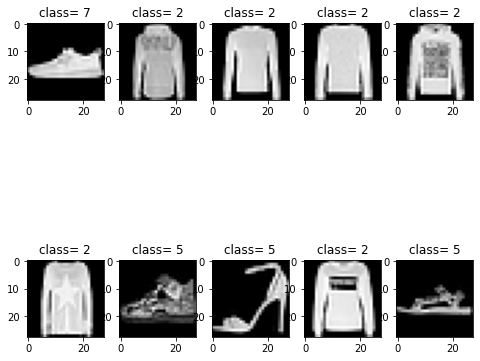

In [83]:
X_plt,y_plt,_,_ = dataprocess_tri(X_train_full,y_train_full,X_test_full,y_test_full)
visualization(X_plt,y_plt)

#Problem 2
- PEGASOS

In [0]:
def pegasos(X_train,y_train, B=20,lambda_=2,Iter=50):
    # lambda_: lambda_strongly_convex
    # B: batch size
    w = np.zeros(X_train.shape[1])  # initialize w
    W = np.zeros((Iter,X_train.shape[1]))
    for iteration in range(Iter):
        idx = np.random.randint(0,len(X_train),B)
        A_x = X_train[idx]
        A_y = y_train[idx]
        idx_sub = [i for i in range(B) if A_y[i]*w@A_x[i]<1]
        A_x_sub = A_x[idx_sub]
        A_y_sub = A_y[idx_sub]
        yita = 1/((iteration+1)*lambda_)
        delta_t = lambda_*w - yita/B*A_y_sub@A_x_sub
        w_ = w - yita*delta_t
        w = min(1,1/math.sqrt(lambda_)/math.sqrt(sum(w_**2)))*w_
        W[iteration] = w
    return W

In [0]:
def evaluation(W,X_train,y_train,X_test,y_test):
    # input:    W: weights for each iteration, (iteration#,784)
    #           X,y
    # output:   err_train, err_test and corresponding plots
    err_train = np.count_nonzero(np.sign(W@X_train.T)!=y_train,axis=1)/len(y_train)
    err_test = np.count_nonzero(np.sign(W@X_test.T)!=y_test,axis=1)/len(y_test)
    print('best test error:',err_test[-1],'best training error:',err_train[-1])
    plots(err_train,err_test)

In [0]:
def plots(err_train=[],err_test=[]):
    if len(err_train)>0:
        plt.plot(np.arange(len(err_train)),err_train)
        plt.xlabel('iteration')
        plt.ylabel('error')
        plt.title("training error vs iteration")
        plt.show()
    if len(err_test)>0:
        plt.plot(np.arange(len(err_test)),err_test)
        plt.xlabel('iteration')
        plt.ylabel('error')
        plt.title('test error vs iteration')

best test error: 0.005 best training error: 0.00625


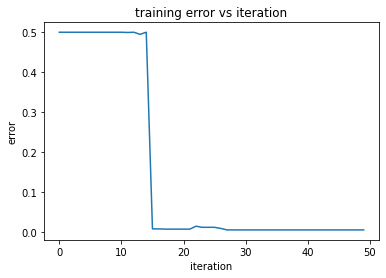

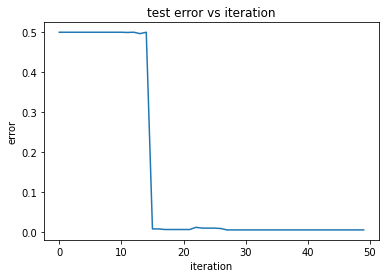

In [303]:
W = pegasos(X_train,y_train)
evaluation(W,X_train,y_train,X_test,y_test)

# Problem 3
- adagrad
- permutation needed

In [0]:
def permutate_data(X,y):
    idx = np.random.permutation(len(y))
    X_pmt = X.copy()
    y_pmt = y.copy()
    X_pmt = X_pmt[idx]
    y_pmt = y_pmt[idx]
    return X_pmt,y_pmt

In [0]:
def diag_inv(G):
    diag = [1/G[i][i] for i in range(len(G))]
    G = np.zeros((len(G),len(G)))
    np.fill_diagonal(G,diag)
    return G

In [0]:
def updateG(G,xt,yt):
    diag = [math.sqrt((G[i,i])**2+(yt*xt[i])**2) for i in range(len(xt))]
    g = np.zeros((len(G),len(G)))
    np.fill_diagonal(g,diag)
    return g

In [0]:
def adagrad_svm(X_train,y_train,iteration=100):
    # G_diag = np.random.random_integers(1,size=X_train.shape[1])
    # G = np.zeros((X_train.shape[1],X_train.shape[1]))
    # np.fill_diagonal(G,G_diag)
    G = np.eye(X_train.shape[1])*100
    yita = 0.01
    w = np.zeros(X_train.shape[1])
    W = np.zeros((iteration,X_train.shape[1]))
    err_train = []
    err_test = []
    for t in range(iteration):
        if y_train[t]*(w@X_train[t])<1:
            deltaf = -y_train[t]*X_train[t]
        else:
            deltaf = np.zeros(X_train.shape[1])
        w -= yita*diag_inv(G)@deltaf
        W[t] = w
        G = updateG(G,X_train[t],y_train[t])
    return W

best test error: 0.009 best training error: 0.012833333333333334


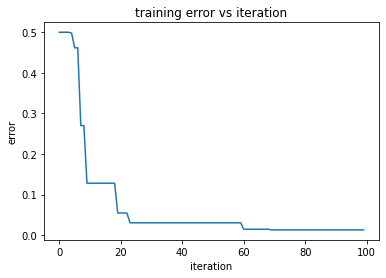

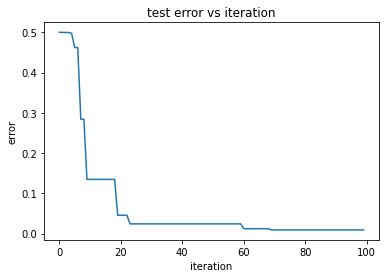

In [308]:
X_train, y_train = permutate_data(X_train,y_train)
W = adagrad_svm(X_train,y_train)
evaluation(W,X_train, y_train, X_test, y_test)

# problem 5
- one vs one
- pegasos based multi-classfier

In [0]:
def split_tri(X_train,y_train):
    X_train_1 = np.vstack((X_train[y_train==2],X_train[y_train==5]))
    y_train_1 = np.hstack((y_train[y_train==2],y_train[y_train==5]))
    X_train_1,y_train_1 = permutate_data(X_train_1,y_train_1)
    y_train_1[y_train_1==2] = 1
    y_train_1[y_train_1==5] = -1
    X_train_2 = np.vstack((X_train[y_train==2],X_train[y_train==7]))
    y_train_2 = np.hstack((y_train[y_train==2],y_train[y_train==7]))
    X_train_2,y_train_2 = permutate_data(X_train_2,y_train_2)
    y_train_2[y_train_2==2] = 1
    y_train_2[y_train_2==7] = -1

    X_train_3 = np.vstack((X_train[y_train==5],X_train[y_train==7]))
    y_train_3 = np.hstack((y_train[y_train==5],y_train[y_train==7]))
    X_train_3,y_train_3 = permutate_data(X_train_3,y_train_3)
    y_train_3[y_train_3==5] = 1
    y_train_3[y_train_3==7] = -1

    return X_train_1,y_train_1,X_train_2,y_train_2,X_train_3,y_train_3

In [0]:
def det_class(predicts_float):
    #input:     predicts, (3,), e.g. [-1,1,-1]
    #output:    one of the classes{2,5,7}
    predicts = np.sign(predicts_float)
    # certain cases
    if predicts[1]==-1 and predicts[2]==-1:
        return 7
    if predicts[0]==-1 and predicts[2]==1:
        return 5
    if predicts[0]==1 and predicts[1]==1:
        return 2
    # uncertain cases
    L = [2,5,7]
    num_2 = predicts_float[0]+predicts_float[1]
    num_5 = -predicts_float[0]+predicts_float[2]
    num_7 = -predicts_float[1]-predicts_float[2]
    return L[np.argmax([num_2,num_5,num_7])]
    

In [0]:
def multiclass(X_train,y_train,X_test,y_test):
    X_train_1,y_train_1,X_train_2,y_train_2,X_train_3,y_train_3 = split_tri(X_train,y_train)
    # 3 classifiers on label 2,5,7
    # do NOT use adagrad, it sucks!
    W_1 = pegasos(X_train_1,y_train_1,Iter = 400)
    W_2 = pegasos(X_train_2,y_train_2,Iter = 400)
    W_3 = pegasos(X_train_3,y_train_3,Iter = 400)
    Y_train_pred = np.zeros((len(W_1),len(y_train),3))
    Y_train_pred[:,:,0] = W_1@X_train.T
    Y_train_pred[:,:,1] = W_2@X_train.T
    Y_train_pred[:,:,2] = W_3@X_train.T
    Y_test_pred = np.zeros((len(W_1),len(y_test),3))
    Y_test_pred[:,:,0] = W_1@X_test.T
    Y_test_pred[:,:,1] = W_2@X_test.T
    Y_test_pred[:,:,2] = W_3@X_test.T
    err_train = []
    err_test = []
    for i in range(len(W_1)):
        seq = map(det_class,Y_train_pred[i,:,:])
        result = np.fromiter(seq, dtype=np.int)
        err_train.append(np.count_nonzero(result!=y_train)/len(y_train))
        seq = map(det_class,Y_test_pred[i,:,:])
        result = np.fromiter(seq, dtype=np.int)
        err_test.append(np.count_nonzero(result!=y_test)/len(y_test))
    return err_train,err_test

best test error: 0.04033333333333333 best training error: 0.03944444444444444


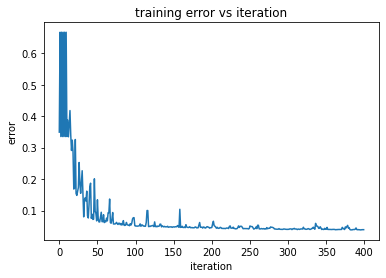

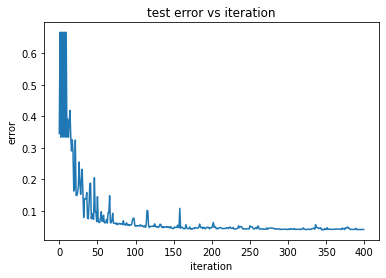

In [313]:
X_train, y_train, X_test, y_test = dataprocess_tri(X_train_full,y_train_full,X_test_full,y_test_full)
err_train,err_test = multiclass(X_train,y_train,X_test,y_test)
print('best test error:',err_test[-1],'best training error:',err_train[-1])
plots(err_train,err_test)

# Problem 6

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #TODO : Design your network, you are allowed to explore your own architecture
        #       But you should achieve a better overall accuracy than the baseline network.
        #       Also, if you do design your own network, include an explanation 
        #       for your choice of network and how it may be better than the 
        #       baseline network in your latex.
        
        #Begin Your Code
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,16,5,stride=1, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,32,5,stride=1, padding=2)
        self.drop = nn.Dropout2d(p=0.5)
        self.out = nn.Linear(32 * 7 * 7, 10)

        #End Your Code

    def forward(self, x):

      #TODO : Implement the forward function that applies the layers you have created to the input

      #Begin Your Code
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.drop(x)
      x = x.view(-1, 32*7*7)          
      x = self.out(x)
      
      return x

      #End Your Code


net = Net()

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [0]:
def data_cnn(X,y,X_t,y_t):
    X_train = X.copy()
    y_train = y.copy()
    X_test = X_t.copy()
    y_test = y_t.copy()
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5],X_train[y_train==7]))
    X_train = (X_train-127.5)/127.5
    X_train = X_train.reshape(len(X_train),1,28,28).astype(np.float32)
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5],y_train[y_train==7]))
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5],X_test[y_test==7]))
    X_test = X_test.reshape(len(X_test),1,28,28).astype(np.float32)
    X_test = X_test-127.5/127.5
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5],y_test[y_test==7]))
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test)
    return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = data_cnn(X_train_full,y_train_full,X_test_full,y_test_full)

In [13]:
overall_step = 0
B = 20
#TODO : Select appropriate number of epochs

#Begin Your Code
#training time
iteration = 1000
err_train = []
total = len(X_train)
#End Your Code

for epoch in range(iteration):  # loop over the dataset multiple times
    running_loss = 0
    correct = 0
    # idx = np.random.randint(0,len(X_train),B)
    # X = X_train[idx]
    # y = y_train[idx]

    # zero the parameter gradients
    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = net(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.data, 1)
    # correct += (predicted == labels).sum().item()
    correct = (predicted == y_train).sum().item()
    err_train.append(1-correct/total)
    # print statistics
    print('epoch:',epoch,'error:',1-correct/total)

print('Finished Training, best train accuracy:',min(err_train))
plots(err_train=err_train)

epoch: 0 error: 0.9312222222222222
epoch: 1 error: 0.5650555555555555
epoch: 2 error: 0.4471666666666667
epoch: 3 error: 0.35738888888888887
epoch: 4 error: 0.3125555555555556
epoch: 5 error: 0.32205555555555554
epoch: 6 error: 0.3211666666666667
epoch: 7 error: 0.27027777777777773
epoch: 8 error: 0.24861111111111112
epoch: 9 error: 0.21166666666666667
epoch: 10 error: 0.18899999999999995
epoch: 11 error: 0.17133333333333334
epoch: 12 error: 0.15161111111111114
epoch: 13 error: 0.14649999999999996
epoch: 14 error: 0.1427222222222222
epoch: 15 error: 0.1353888888888889
epoch: 16 error: 0.12883333333333336
epoch: 17 error: 0.12372222222222218
epoch: 18 error: 0.11655555555555552
epoch: 19 error: 0.11499999999999999
epoch: 20 error: 0.10883333333333334
epoch: 21 error: 0.10583333333333333
epoch: 22 error: 0.10255555555555551
epoch: 23 error: 0.10083333333333333
epoch: 24 error: 0.09516666666666662
epoch: 25 error: 0.0935555555555555
epoch: 26 error: 0.08755555555555561
epoch: 27 error: 0.

NameError: ignored

In [69]:
correct = 0
total = 0
with torch.no_grad():
    outputs = net(X_test)
    _, predicted = torch.max(outputs.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 97 %
